# Análise de correlação entre os votos em partidos (PL e PT) e atributos socioeconômicos.

In [118]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
# Dados
dep_fed_results = pd.read_csv('/content/dep_fed_results_202501111945.csv')
distribuicao_populacao = pd.read_csv('/content/distribuicao_populacao.csv')
pib_municipios = pd.read_csv('/content/pib_municipios.csv')
municipios = gpd.read_file('/content/SC_Municipios_2023.shp')

In [120]:
# Padronizar nomes dos municípios
dep_fed_results['nm_municipio'] = dep_fed_results['nm_municipio'].str.upper()
distribuicao_populacao['nm_mun'] = distribuicao_populacao['nm_mun'].str.upper()
pib_municipios['nm_mun'] = pib_municipios['nm_mun'].str.upper()
municipios['NM_MUN'] = municipios['NM_MUN'].str.upper()

# Filtrar dados relevantes
pib_municipios = pib_municipios[pib_municipios['sg_uf'] == 'SC']
pib_municipios = pib_municipios[pib_municipios['ano'] == 2020]

#distribuicao_populacao = distribuicao_populacao[distribuicao_populacao['cd_municipio'].astype(str).str.startswith('42')]

In [121]:
# Partidos analisados: PT e PL
partidos_interesse = ['PL', 'PT']
dep_fed_results_pl_pt = dep_fed_results[dep_fed_results['sg_partido'].isin(partidos_interesse)]

In [122]:
# Votos por município para cada partido
votos_por_municipio_partido = dep_fed_results_pl_pt.groupby(['nm_municipio', 'sg_partido'])['qt_votos_nominais'].sum().reset_index()

In [123]:
# Merge das informações das diferentes fontes
dados_completos = votos_por_municipio_partido.merge(distribuicao_populacao, left_on='nm_municipio', right_on='nm_mun', how='left')
dados_completos = dados_completos.merge(pib_municipios[['nm_mun', 'pib', 'pip_per_capita']], on='nm_mun', how='left')

In [124]:
# Obter % dos votos para cada instância
dados_completos['perc_votos'] = dados_completos['qt_votos_nominais'] / dados_completos['tot_pop']

In [125]:
# Selecionar os candidatos mais votados por partido
mais_votados_por_partido = dep_fed_results.loc[
    dep_fed_results.groupby('sg_partido')['qt_votos_nominais'].idxmax()
]

# Ordenar por quantidade de votos
mais_votados_por_partido = mais_votados_por_partido.sort_values(by='qt_votos_nominais', ascending=False)

# Exibir os resultados
print("Candidatos mais votados por partido:")
print(mais_votados_por_partido[['nm_candidato', 'sg_partido', 'qt_votos_nominais']])


Candidatos mais votados por partido:
                          nm_candidato     sg_partido  qt_votos_nominais
90087          VALDIR VITAL COBALCHINI            MDB              20745
21045      CARMEN EMÍLIA BONFÁ ZANOTTO      CIDADANIA              18908
3577                    SILVIO DREVECK             PP              17902
44822              CAIO CESAR TOKARSKI          UNIÃO              15907
18496          ANA PAULA DE SOUZA LIMA             PT              14033
32298       CAROLINE RODRIGUES DE TONI             PL              13140
23327                 PAULO JOSÉ CUNHA            PSD              11468
22146         ROSINEI DE SOUZA HORÁCIO           PODE              11362
55336                   MARCELO WERNER            PSC              11170
12198            GILSON MARQUES VIEIRA           NOVO              10778
66540                   EUNICE ANTUNES           PSOL               8831
70191        FABIANO FRANCISCO CAITANO           PSDB               8266
56962         

Quantidade absoluta de brancos, pardos e pretos por partido mais votado:
              qtd_branca  qtd_preta  qtd_parda
sg_partido                                    
CIDADANIA         267385      14447     105567
MDB               856220      52592     299669
NOVO              800132      51562     200965
PATRIOTA            9759        219        952
PDT                64799       2117      12114
PL               1101732      61150     337428
PODE              163691       6583      47836
PP                278705      14417      89064
PSB                49850       1950      10970
PSD               340891      15732      70926
PSDB              465630      44134     194853
PT               1045791      76142     387428
REPUBLICANOS       40518       2309      12037
UNIÃO            1014143      84111     250340


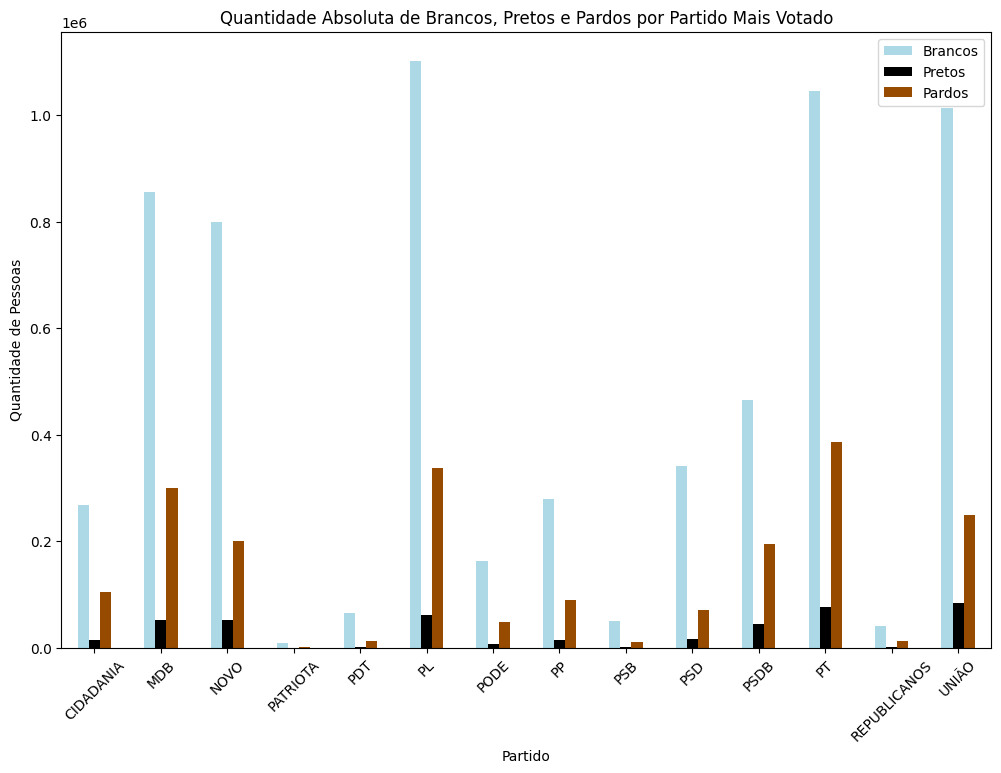

Proporção média de população branca, preta e parda por partido mais votado:
              perc_branca  perc_preta  perc_parda
sg_partido                                       
CIDADANIA       68.408333    3.395833   27.983333
MDB             73.431395    3.234884   22.098837
NOVO            78.283333    3.966667   17.466667
PATRIOTA        89.100000    2.000000    8.700000
PDT             68.350000    2.550000   28.850000
PL              71.103636    3.529091   25.105455
PODE            77.622222    2.233333   19.688889
PP              76.300000    3.416667   20.133333
PSB             79.400000    3.150000   17.200000
PSD             83.095652    2.665217   13.682609
PSDB            78.059091    3.531818   18.281818
PT              68.165476    3.971429   26.970238
REPUBLICANOS    75.650000    3.050000   20.950000
UNIÃO           78.193333    4.533333   16.640000


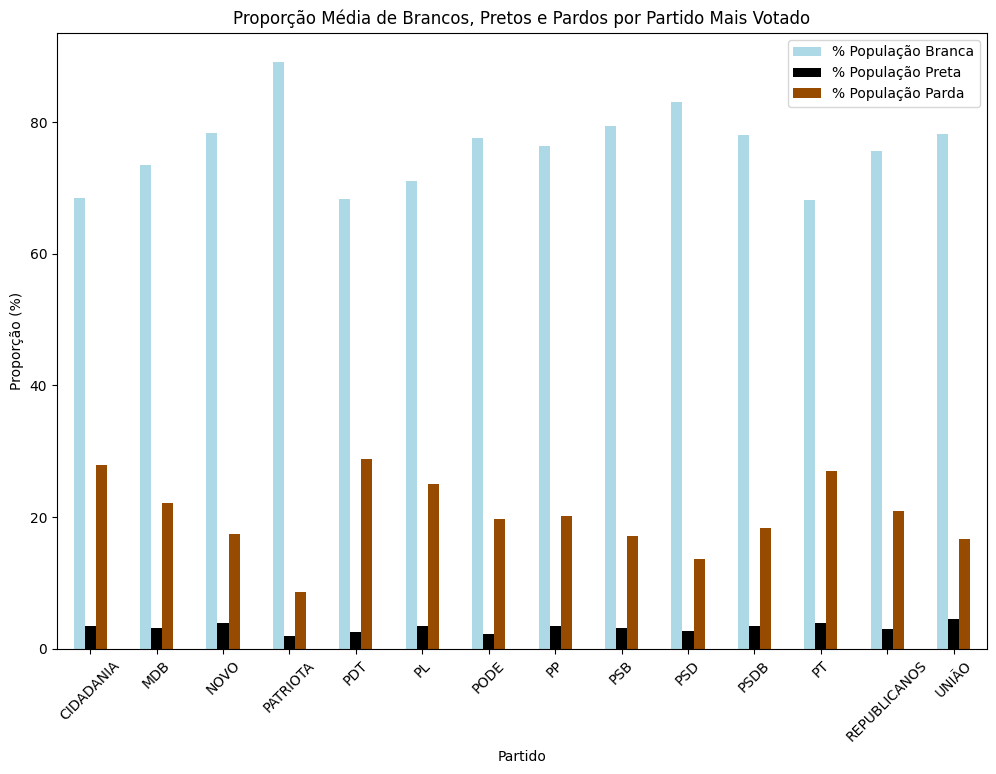

In [126]:
# Cruzando dados raciais com os resultados por partido
dados_completos = municipios.merge(distribuicao_populacao, left_on='NM_MUN', right_on='nm_mun')
dados_completos = dados_completos.merge(dados_votacao[['NM_MUN', 'sg_partido']], on='NM_MUN')

# Incluindo proporção de população parda
dados_completos = dados_completos[['NM_MUN', 'tot_pop', 'perc_branca', 'perc_preta', 'perc_parda', 'sg_partido']].dropna()

# Calculando a quantidade absoluta de cada grupo racial
dados_completos['qtd_branca'] = (dados_completos['tot_pop'] * dados_completos['perc_branca'] / 100).astype(int)
dados_completos['qtd_preta'] = (dados_completos['tot_pop'] * dados_completos['perc_preta'] / 100).astype(int)
dados_completos['qtd_parda'] = (dados_completos['tot_pop'] * dados_completos['perc_parda'] / 100).astype(int)

# Estatísticas descritivas: quantidade absoluta por partido
quantidades_partido = dados_completos.groupby('sg_partido')[['qtd_branca', 'qtd_preta', 'qtd_parda']].sum()
print("Quantidade absoluta de brancos, pardos e pretos por partido mais votado:")
print(quantidades_partido)

# Visualizando a quantidade absoluta
quantidades_partido.plot(kind='bar', figsize=(12, 8), color=['#add8e6', '#000000', '#964B00'])
plt.title('Quantidade Absoluta de Brancos, Pretos e Pardos por Partido Mais Votado')
plt.ylabel('Quantidade de Pessoas')
plt.xlabel('Partido')
plt.legend(['Brancos', 'Pretos', 'Pardos'])
plt.xticks(rotation=45)
plt.show()

# Estatísticas descritivas: proporção média por partido
proporcoes_partido = dados_completos.groupby('sg_partido')[['perc_branca', 'perc_preta', 'perc_parda']].mean()
print("Proporção média de população branca, preta e parda por partido mais votado:")
print(proporcoes_partido)

# Visualizando proporção média
proporcoes_partido.plot(kind='bar', figsize=(12, 8), color=['#add8e6', '#000000', '#964B00'])
plt.title('Proporção Média de Brancos, Pretos e Pardos por Partido Mais Votado')
plt.ylabel('Proporção (%)')
plt.xlabel('Partido')
plt.legend(['% População Branca', '% População Preta', '% População Parda'])
plt.xticks(rotation=45)
plt.show()


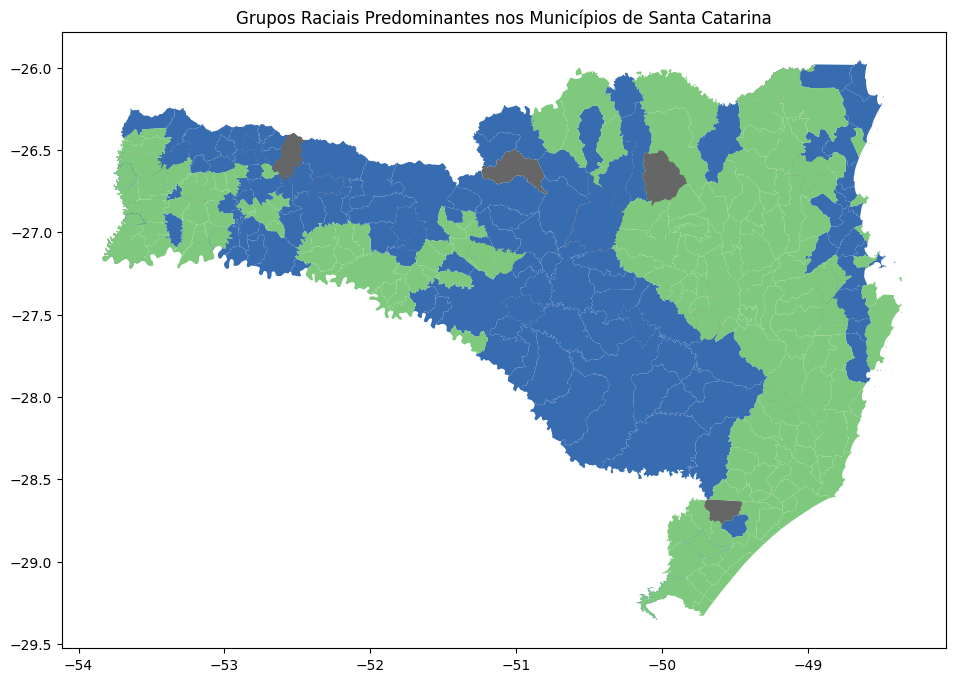

Estatísticas médias por grupo racial:
              perc_branca  perc_preta  perc_parda
grupo_racial                                     
0               83.886631    2.312299   13.429947
1               67.596825    3.541270   27.851587
2               27.023333   10.673333   61.016667


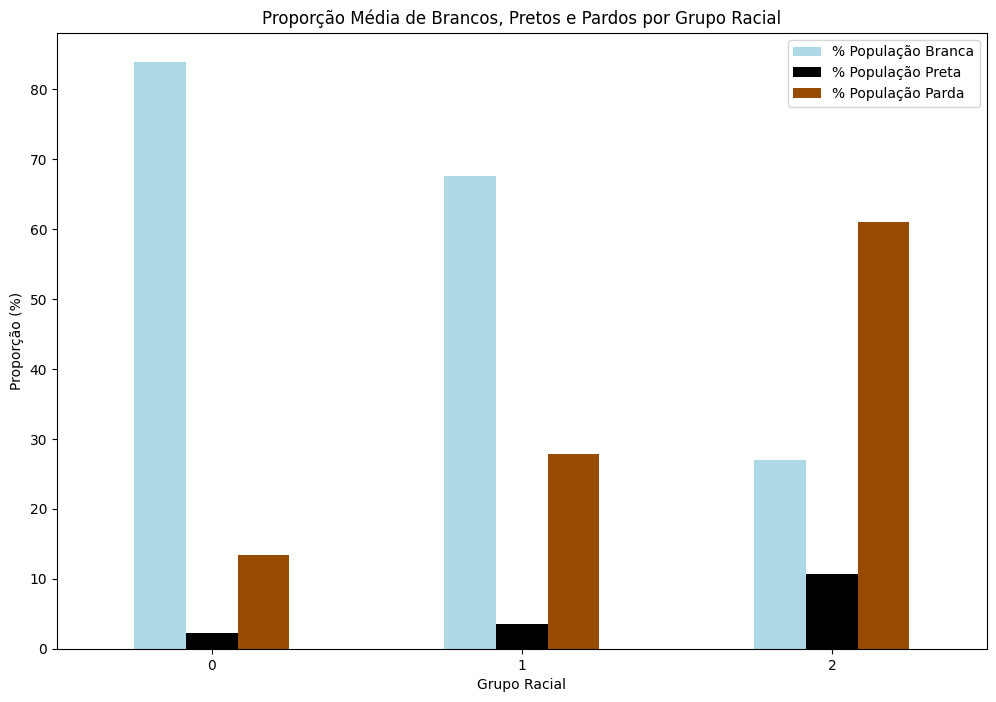

In [127]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Filtrar dados necessários
dados_raciais = municipios.merge(distribuicao_populacao, left_on='NM_MUN', right_on='nm_mun')
dados_raciais = dados_raciais[['NM_MUN', 'perc_branca', 'perc_preta', 'perc_parda', 'geometry']].dropna()

# Aplicar K-Means para agrupar municípios por similaridade racial (branca, preta e parda)
n_clusters = 3  # Número de grupos raciais
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
dados_raciais['grupo_racial'] = kmeans.fit_predict(dados_raciais[['perc_branca', 'perc_preta', 'perc_parda']])

# Criar mapa com os grupos raciais
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dados_raciais.plot(column='grupo_racial', cmap='Accent', legend=False, ax=ax)
plt.title('Grupos Raciais Predominantes nos Municípios de Santa Catarina')
plt.show()

# Estatísticas descritivas por grupo
estatisticas_grupos = dados_raciais.groupby('grupo_racial')[['perc_branca', 'perc_preta', 'perc_parda']].mean()
print("Estatísticas médias por grupo racial:")
print(estatisticas_grupos)

# Visualizar estatísticas médias
estatisticas_grupos.plot(kind='bar', figsize=(12, 8), color=['#add8e6', '#000000', '#964B00'])
plt.title('Proporção Média de Brancos, Pretos e Pardos por Grupo Racial')
plt.ylabel('Proporção (%)')
plt.xlabel('Grupo Racial')
plt.legend(['% População Branca', '% População Preta', '% População Parda'])
plt.xticks(rotation=0)
plt.show()


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 


Grupo 0:
Municípios: ABDON BATISTA, ABELARDO LUZ, AGROLÂNDIA, AGRONÔMICA, ÁGUA DOCE, ÁGUAS DE CHAPECÓ, ÁGUAS FRIAS, ÁGUAS MORNAS, ALFREDO WAGNER, ALTO BELA VISTA, ANCHIETA, ANCHIETA, ANGELINA, ANITA GARIBALDI, ANITÁPOLIS, ANTÔNIO CARLOS, ANTÔNIO CARLOS, APIÚNA, ARABUTÃ, ARAQUARI, ARARANGUÁ, ARMAZÉM, ARROIO TRINTA, ARVOREDO, ASCURRA, ATALANTA, AURORA, AURORA, BALNEÁRIO ARROIO DO SILVA, BALNEÁRIO CAMBORIÚ, BALNEÁRIO BARRA DO SUL, BALNEÁRIO GAIVOTA, BANDEIRANTE, BARRA BONITA, BARRA BONITA, BARRA VELHA, BELA VISTA DO TOLDO, BELMONTE, BELMONTE, BENEDITO NOVO, BIGUAÇU, BLUMENAU, BOCAINA DO SUL, BOMBINHAS, BOM JARDIM DA SERRA, BOM JESUS, BOM JESUS, BOM JESUS, BOM JESUS, BOM JESUS, BOM JESUS DO OESTE, BOM RETIRO, BOTUVERÁ, BRAÇO DO NORTE, BRAÇO DO TROMBUDO, BRUNÓPOLIS, BRUSQUE, CAÇADOR, CAIBI, CALMON, CAMBORIÚ, CAPÃO ALTO, CAMPO ALEGRE, CAMPO ALEGRE, CAMPO BELO DO SUL, CAMPO ERÊ, CAMPOS NOVOS, CANELINHA, CANOINHAS, CAPINZAL, CAPIVARI DE BAIXO, CATANDUVAS, CATANDUVAS, CAXAMBU DO SUL, CELSO RAM

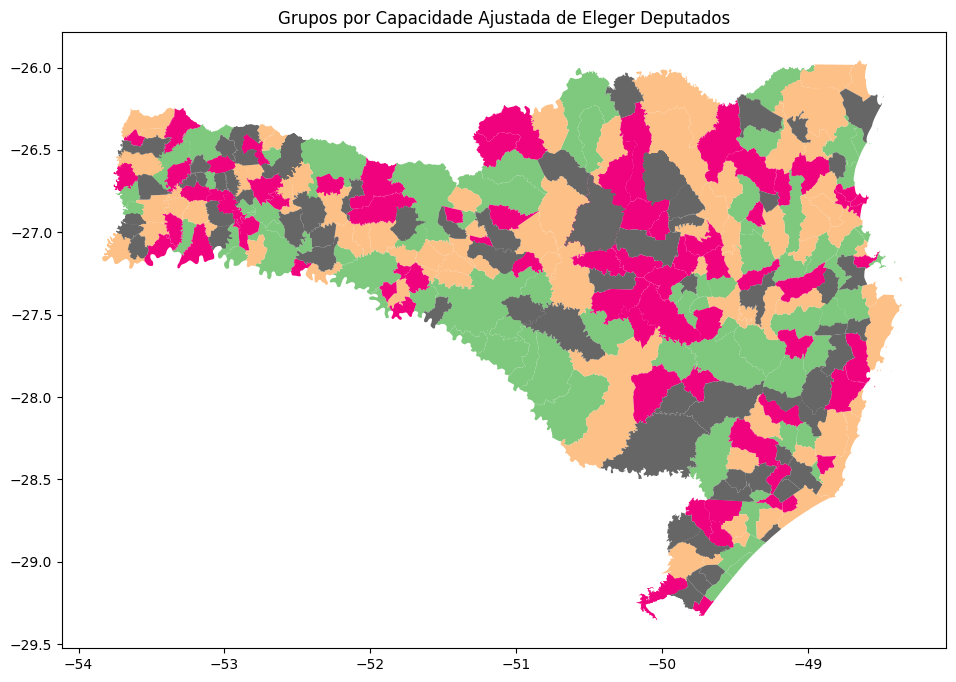

In [128]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Definir parâmetros
total_votos = 5600000  # Total de votos
votos_por_deputado = total_votos / 16  # Número de votos necessários para eleger um deputado
capacidade_maxima_votos = 4.05 * votos_por_deputado  # Capacidade máxima de votos por grupo

# Criar uma coluna de votos totais estimados
num_municipios = len(dados_raciais)
votos_por_municipio = total_votos / num_municipios
dados_raciais['votos_totais'] = votos_por_municipio

# Inicializar os grupos
dados_raciais['grupo'] = -1  # Inicializar os grupos como não atribuídos
grupos_atribuidos = []

# Clusterização ajustada
grupo_atual = 0  # Contador para grupos numerados corretamente
while True:
    # Selecionar municípios ainda não atribuídos
    nao_atribuidos = dados_raciais[dados_raciais['grupo'] == -1]

    if nao_atribuidos.empty:
        break  # Se não há mais municípios para atribuir, finalizar

    # Agrupar pelo KMeans para o cluster atual
    kmeans = KMeans(n_clusters=1, random_state=42)
    nao_atribuidos['sub_grupo'] = kmeans.fit_predict(nao_atribuidos[['votos_totais']])

    # Atribuir municípios ao grupo até atingir a capacidade máxima
    total_votos_grupo = 0
    municipios_grupo = []

    for idx, row in nao_atribuidos.iterrows():
        if total_votos_grupo + row['votos_totais'] <= capacidade_maxima_votos:
            total_votos_grupo += row['votos_totais']
            municipios_grupo.append(idx)
        else:
            break

    # Se o grupo formado não consegue eleger ao menos 1 deputado, finalizar
    if total_votos_grupo < votos_por_deputado:
        break

    # Marcar os municípios como pertencentes ao grupo atual
    dados_raciais.loc[municipios_grupo, 'grupo'] = grupo_atual
    grupos_atribuidos.append((grupo_atual, total_votos_grupo))
    grupo_atual += 1

# Exibir os grupos ajustados
for grupo, total_votos in grupos_atribuidos:
    municipios_no_grupo = dados_raciais[dados_raciais['grupo'] == grupo]
    print(f"\nGrupo {grupo}:")
    print(f"Municípios: {', '.join(municipios_no_grupo['NM_MUN'].values)}")
    print(f"Total de votos: {total_votos}")
    print(f"Capacidade de eleger deputados: {total_votos / votos_por_deputado:.2f}")

# Para os municípios não agrupados, forçá-los ao último grupo
dados_raciais.loc[dados_raciais['grupo'] == -1, 'grupo'] = grupo_atual

# Exibir informações dos municípios restantes, se houver
if not dados_raciais[dados_raciais['grupo'] == grupo_atual].empty:
    municipios_restantes = dados_raciais[dados_raciais['grupo'] == grupo_atual]
    print(f"\nGrupo {grupo_atual} (Restante):")
    print(f"Municípios: {', '.join(municipios_restantes['NM_MUN'].values)}")
    print(f"Total de votos: {municipios_restantes['votos_totais'].sum()}")
    print(f"Capacidade de eleger deputados: {municipios_restantes['votos_totais'].sum() / votos_por_deputado:.2f}")

# Plotar o mapa atualizado
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dados_raciais.plot(column='grupo', cmap='Accent', legend=False, ax=ax)
plt.title('Grupos por Capacidade Ajustada de Eleger Deputados')
plt.show()


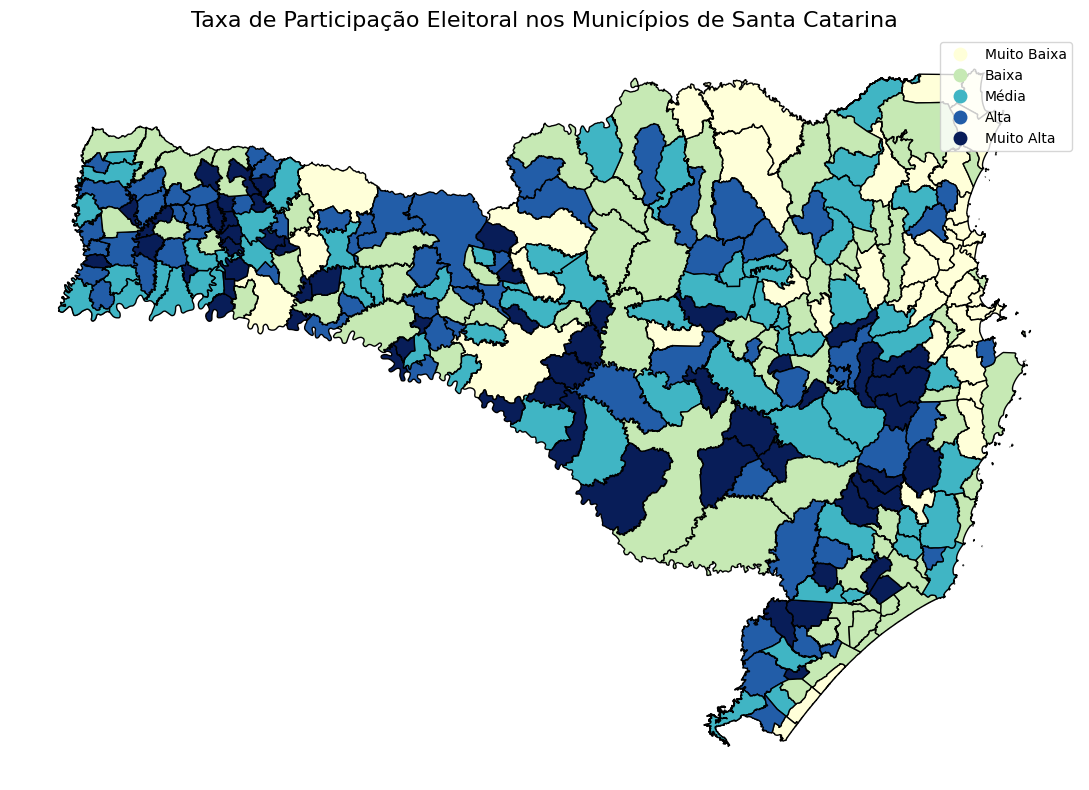

Estatísticas da Taxa de Participação por Categoria:
             count       mean        std        min        25%        50%  \
categoria                                                                   
Muito Baixa   69.0  33.426200  16.571796   1.375113  17.988965  41.990490   
Baixa         68.0  51.407015   1.599834  48.679594  50.199383  51.520833   
Média         69.0  57.068482   1.678890  54.593138  55.607477  56.688078   
Alta          68.0  63.961201   2.336940  60.281510  61.892144  63.532335   
Muito Alta    69.0  78.837525  21.065263  68.104521  70.295822  72.693850   

                   75%         max  
categoria                           
Muito Baixa  46.280652   48.551231  
Baixa        52.687075   54.567618  
Média        58.425382   60.217721  
Alta         66.064676   68.072289  
Muito Alta   76.520270  208.863198  


<ipython-input-129-98e620de44af>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estatisticas_participacao = dados_eleitorais.groupby('categoria')['taxa_participacao'].describe()


In [129]:
# Supondo que dep_fed_results tenha os votos válidos por município
# e distribuicao_populacao tenha a população votante total.

# Calcular a taxa de participação eleitoral
dados_eleitorais = municipios.merge(distribuicao_populacao, left_on='NM_MUN', right_on='nm_mun')
dados_eleitorais = dados_eleitorais.merge(dep_fed_results.groupby('nm_municipio')['qt_votos_nominais'].sum().reset_index(),
                                          left_on='NM_MUN', right_on='nm_municipio')

dados_eleitorais['taxa_participacao'] = (dados_eleitorais['qt_votos_nominais'] / dados_eleitorais['tot_pop']) * 100

# Remover valores nulos ou inconsistentes
dados_eleitorais = dados_eleitorais[['NM_MUN', 'taxa_participacao', 'geometry']].dropna()

# Criar classes para visualização (quintis)
dados_eleitorais['categoria'] = pd.qcut(dados_eleitorais['taxa_participacao'],
                                        q=5,
                                        labels=['Muito Baixa', 'Baixa', 'Média', 'Alta', 'Muito Alta'])

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dados_eleitorais.plot(column='categoria', cmap='YlGnBu', legend=True, ax=ax, edgecolor='black')

# Ajustar título e layout
plt.title('Taxa de Participação Eleitoral nos Municípios de Santa Catarina', fontsize=16)
plt.axis('off')  # Remover eixos para um visual limpo
plt.tight_layout()

# Mostrar o mapa
plt.show()

# Estatísticas descritivas
estatisticas_participacao = dados_eleitorais.groupby('categoria')['taxa_participacao'].describe()
print("Estatísticas da Taxa de Participação por Categoria:")
print(estatisticas_participacao)


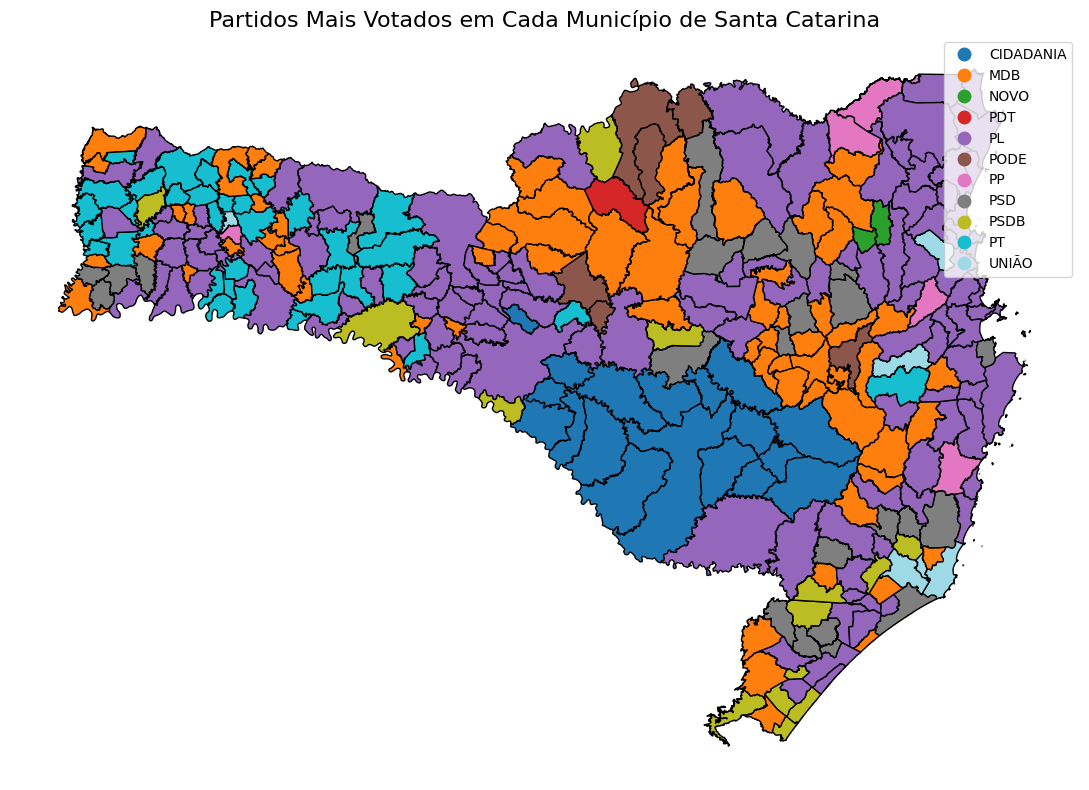

Número de municípios onde cada partido foi o mais votado:
sg_partido
PL           117
MDB           66
PT            36
PSD           24
CIDADANIA     18
PSDB          14
PODE           6
UNIÃO          6
PP             5
NOVO           2
PDT            1
Name: count, dtype: int64


In [130]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Agrupar votos por município e partido para encontrar o partido mais votado
votos_por_municipio = dep_fed_results.groupby(['nm_municipio', 'sg_partido'])['qt_votos_nominais'].sum().reset_index()

# Encontrar o partido mais votado em cada município
partido_mais_votado = votos_por_municipio.loc[votos_por_municipio.groupby('nm_municipio')['qt_votos_nominais'].idxmax()]

# Adicionar os resultados ao GeoDataFrame dos municípios
dados_partidos = municipios.merge(partido_mais_votado, left_on='NM_MUN', right_on='nm_municipio')

# Criar um mapa com os partidos mais votados
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dados_partidos.plot(column='sg_partido', cmap='tab20', legend=True, ax=ax, edgecolor='black')

# Ajustar o título e remover eixos para melhor visualização
plt.title('Partidos Mais Votados em Cada Município de Santa Catarina', fontsize=16)
plt.axis('off')  # Remover eixos
plt.tight_layout()

# Mostrar o mapa
plt.show()

# Estatísticas: Contar quantos municípios cada partido liderou
municipios_por_partido = dados_partidos['sg_partido'].value_counts()
print("Número de municípios onde cada partido foi o mais votado:")
print(municipios_por_partido)
